In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors

# Load dataset
df = pd.read_csv("Iris.csv")

# Drop Id column if present
if "Id" in df.columns:
    df = df.drop("Id", axis=1)

# Encode labels
le = LabelEncoder()
df["Species"] = le.fit_transform(df["Species"])

X = df.drop("Species", axis=1).values
y = df["Species"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

labels = np.unique(y)
class_names = le.classes_


In [14]:
def manual_smote(X, y, target_class, setting="random", n_samples=20):
    X_minority = X[y == target_class]
    synthetic_samples = []

    if setting == "random":
        # (a) Random two-sample interpolation
        for _ in range(n_samples):
            i, j = np.random.choice(len(X_minority), 2, replace=False)
            lam = np.random.rand()
            x_new = lam * X_minority[i] + (1 - lam) * X_minority[j]
            synthetic_samples.append(x_new)

    elif setting == "nearest":
        # (b) Nearest-neighbor interpolation
        nn = NearestNeighbors(n_neighbors=2).fit(X_minority)
        for i in range(len(X_minority)):
            _, idx = nn.kneighbors([X_minority[i]])
            j = idx[0][1]
            lam = np.random.rand()
            x_new = lam * X_minority[i] + (1 - lam) * X_minority[j]
            synthetic_samples.append(x_new)

    synthetic_samples = np.array(synthetic_samples)
    y_new = np.full(len(synthetic_samples), target_class)

    X_resampled = np.vstack([X, synthetic_samples])
    y_resampled = np.hstack([y, y_new])

    return X_resampled, y_resampled


In [15]:
def train_and_get_probs(X_train, y_train, X_test, setting, target_class):
    # Oversample target class
    X_res, y_res = manual_smote(X_train, y_train, target_class=target_class,
                                setting=setting, n_samples=30)

    # Binary labels (one-vs-rest)
    y_train_binary = (y_res == target_class).astype(int)

    # Train regression
    model = LinearRegression().fit(X_res, y_train_binary)

    # Predict continuous scores
    y_scores = model.predict(X_test)

    return y_scores


In [16]:
def compute_roc(y_true, y_scores, pos_label=1):
    thresholds = np.linspace(0, 1, 101)
    tprs, fprs = [], []

    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        tp = np.sum((y_true==pos_label) & (y_pred==1))
        fp = np.sum((y_true!=pos_label) & (y_pred==1))
        fn = np.sum((y_true==pos_label) & (y_pred==0))
        tn = np.sum((y_true!=pos_label) & (y_pred==0))

        tpr = tp / (tp+fn) if (tp+fn) > 0 else 0
        fpr = fp / (fp+tn) if (fp+tn) > 0 else 0

        tprs.append(tpr)
        fprs.append(fpr)

    return np.array(fprs), np.array(tprs)

def compute_auc(fprs, tprs):
    return np.trapezoid(tprs, fprs)



In [17]:
def plot_roc_for_setting(setting):
    plt.figure(figsize=(6,5))
    aucs = []

    for cls, name in zip(labels, class_names):
        # Binary labels for this class
        y_true_binary = (y_test == cls).astype(int)

        # Predicted scores
        y_scores = train_and_get_probs(X_train, y_train, X_test, setting, target_class=cls)

        # ROC curve
        fprs, tprs = compute_roc(y_true_binary, y_scores, pos_label=1)
        auc = compute_auc(fprs, tprs)
        aucs.append(auc)

        plt.plot(fprs, tprs, label=f"{name} (AUC={auc:.2f})")

    macro_auc = np.mean(aucs)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({setting}) | Macro-AUC={macro_auc:.2f}")
    plt.legend()
    plt.show()

    return aucs, macro_auc


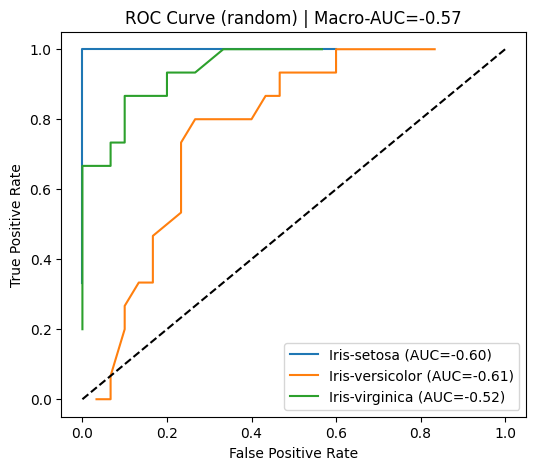

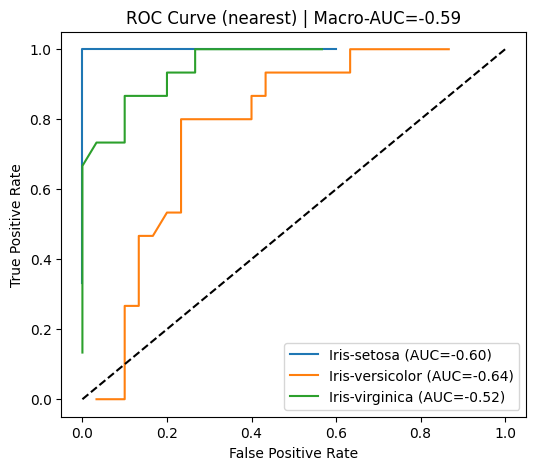

SMOTE (Random): Per-class AUCs = [np.float64(-0.5999999999999999), np.float64(-0.6055555555555556), np.float64(-0.5155555555555555)]  Macro-AUC = -0.5737037037037037
SMOTE (Nearest): Per-class AUCs = [np.float64(-0.5999999999999999), np.float64(-0.6411111111111112), np.float64(-0.5211111111111111)]  Macro-AUC = -0.5874074074074074


In [18]:
aucs_random, macro_auc_random = plot_roc_for_setting("random")
aucs_nearest, macro_auc_nearest = plot_roc_for_setting("nearest")

print("SMOTE (Random): Per-class AUCs =", aucs_random, " Macro-AUC =", macro_auc_random)
print("SMOTE (Nearest): Per-class AUCs =", aucs_nearest, " Macro-AUC =", macro_auc_nearest)
